# Table of Contents

- [Motivation](#Motivation)
- [Installations](#Installations)
- [Audio Features Over Time](#Audio-Features-Over-Time)
    - [Spotify Data Extraction Setup](#Spotify-Data-Extraction-Setup)
    - [Analyze Audio Features over Years](#Analyze-Audio-Features-over-Years)
    - [Most Frequent Genres](#Most-Frequent-Genres)
    - [Popularity prediction based on audio features](#Popularity-prediction-based-on-audio-features)
- [Other Trends in Music](#Other-Trends-in-Music)
    - [Lyrics Over Time](#Lyrics-Over-Time)
    - [Gender Trends](#Gender-Trends)
- [Final Word](#Final-Word)
- [References](#Citations)
- [Further Resources](#Further-Resources)

### Motivation

Music has always been one of the most popular forms of entertainment worldwide. Music streaming services have been growing in popularity and have contributed a larger part of income to the music industry with the advent of Spotify, Apple Music, SoundCloud, Pandora, etc. Streaming services tend to collect metadata on listeners and artists. By analyzing trends in this metadata, we can observe viral musical trends over the past few decades ([1](https://artists.spotify.com/blog/metadata-what-it-is-and-why-it-matters)).

Numerical analysis has long been a tool in the music business from records of album sales, BDS counts of radio spins, and even Billboard chart rankings. Plus, with more of music consumption becoming digital, there is an ever-increasing amount of information available.

In this project, we carried out data mining for tracks from the Spotify API and the top tracks from Billboard (via an API) for every 10 years from 1969 to 2019 to analyze the trends in viral music and have created a random forest regressor to predict whether a song has the required features to be in the top 20% of the popular songs of that year.

### Installations
First, we import the needed libraries. Our main data collection tool is 'Spotipy' which is a lightweight Python library for the Spotify Web API. With Spotipy you get full access to all of the music data provided by the Spotify platform. We also use the library billboard, which provides a Python API to access billboard charts. We have used PyLyrics, which is a wrapper on top of lyrics.wikia.com, to fetch the lyrics of the top music we want to analyze.

In [11]:
import requests
import time
import json
import re
import collections
import wordcloud
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats

import spotipy
import spotipy.util as util
import nltk
from nltk.corpus import stopwords
from PyLyrics import *
import billboard

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error

import warnings


def nltk_download():
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')
nltk_download()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swetawork/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/swetawork/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/swetawork/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Audio Features Over Time
### Spotify Data Extraction Setup

We use instructions from Spotify Developers to set up tokens for API requests ([2](https://developer.spotify.com/documentation/general/guides/authorization-guide/)). The client_id and client_secret are generated to retrieve an access token. In the following functions leading up to the main, we used the following reference as a guide for data extraction; note that we perform requests directly via the Spotify API ([3](https://github.com/AsTimeGoesBy111/Spotify-Music-Data-Analysis/blob/gh-pages/Code/Spotify_Extract_API_Data.py)).

In [12]:
CLIENT_ID = '95b6f9df09d142cc87ffe9a120ccda5b'
CLIENT_SECRET = '375385f5d10644a0b397ceb520a7b039'

token = util.oauth2.SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

cache_token = token.get_access_token()
spotify = spotipy.Spotify(cache_token)

This is a function to extract features for a certain number of top songs using variable year as the query string ([3](https://github.com/AsTimeGoesBy111/Spotify-Music-Data-Analysis/blob/gh-pages/Code/Spotify_Extract_API_Data.py)).

In [13]:
def search_request(keywords, search_type, results_limit, results_offset, track_list, song_ids, artist_ids, album_ids):
    off = str(results_offset)
    lim = str(results_limit)
    results = spotify.search(q='year:' + keywords, type=search_type, limit=lim, offset=off)
    items = results['tracks']['items']
    try:
        for item in items:
            if item['id'] not in song_ids:
                song_ids.append(item['id'] )
            if item['artists'][0]['id'] not in artist_ids:
                artist_ids.append(item['artists'][0]['id'] )
            if item['album']['id'] not in album_ids:
                album_ids.append(item['album']['id'] )
            track = [item['popularity'],item['id'], item['artists'][0]['id'],item['album']['id'],item['name'],item['artists'][0]['name'],
                       item['album']['name'],item['explicit'],item['track_number']]
            track_list.append(track)
    except:
         ValueError

We retrieve artist data to get an individual artist's unique id, list of genres fitting their music, and popularity measure ([3](https://github.com/AsTimeGoesBy111/Spotify-Music-Data-Analysis/blob/gh-pages/Code/Spotify_Extract_API_Data.py)).

In [14]:
def get_artists(artist_ids, artist_data):
    results = spotify.artists(artist_ids)
    try:
        for item in results['artists']:
            artist = [item['id'],item['genres'],item['popularity']]
            artist_data.append(artist)
    except:
        ValueError

#### Available Audio Features

Each song or track (both are used interchangeably) in Spotify can be characterized by many available audio features. We refer to this reference when describing features ([4](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)). The main numerical audio features we studied include the following: <br> <br>
<b>Acousticness:</b> This value describes how acoustic a song is on a scale from 0.0 to 1.0. A score of 1.0 means the song is most likely to be an acoustic one.
<br>
<b>Loudness:</b> The loudness of a track is measured in decibels (dB). The values are averaged across and entire track, and range between -60 to 0 dB. A track is louder if its dB is closer to 0.
<br>
<b>Instrumentalness:</b> This is a relative measure of the vocals in a song on a scale from 0.0 to 1.0. "'Ooh' and 'aah' sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly 'vocal'." A track is more instrumental and therefore has no vocal content as its instrumentalness value approaches 1.0. Generally, values above 0.5 represent instrumental tracks.
<br>
<b>Energy:</b> This value measures the intensity and activity of a track on a scale from 0.0 to 1.0. Typically, energetic tracks feel fast, loud, and noisy”.
<br>
<b>Danceability:</b> “Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity." Danceability scores range from 0.0 to 1.0, with 1.0 being most danceable.
<br>
<b>Valence:</b> This value describes the musical positiveness conveyed by a song, on a scale from 0.0 to 1.0. Tracks with high valence sound more positive (e.g. "happy, cheerful, euphoric"), while tracks with low valence sound more negative (e.g. "sad, depressed, angry").

Here, we retrieve 13 numerical audio features ([3](https://github.com/AsTimeGoesBy111/Spotify-Music-Data-Analysis/blob/gh-pages/Code/Spotify_Extract_API_Data.py)).

In [15]:
def get_audio_feature(songids, audio_features):
    track_ids = ','.join(songids)
    results = spotify.audio_features(track_ids)
    try:
        for item in results:
            audio_feature =  [item['id'],item['tempo'],item['type'],item['key'],item['loudness'],item['mode'],
                  item['liveness'],item['valence'],item['danceability'],item['energy'],
                  item['duration_ms'],item['acousticness'],item['instrumentalness']]
            audio_features.append(audio_feature)
    except:
        ValueError

We retrieve artist data to get an individual album's unique id, list of genres fitting that album, popularity measure, and release date ([3](https://github.com/AsTimeGoesBy111/Spotify-Music-Data-Analysis/blob/gh-pages/Code/Spotify_Extract_API_Data.py)).

In [16]:
def get_albums(album_ids, album_data):
    results = spotify.albums(album_ids)
    try:
        for items in results['albums']:
            album = [items['id'],items['genres'],items['popularity'],items['release_date']]
            album_data.append(album)
    except:
        ValueError

#### Main Method to Drive Spotify API requests

We have four distinct categories of data, exemplified by the functions above: track features, audio features, artist features, and album features. We query data per year and per category, so we merge the data from all four categories _per year_ into a single data frame _per year_ to store it as a .csv file.

In [17]:
import json
def create_dataframes(song_map):
    with open('columns.json') as json_file:
        data = json.load(json_file)
        df1 = pd.DataFrame(song_map['track_list'], columns=data["columns"]["track_columns"])
        df2 = pd.DataFrame(song_map['audio_features'], columns=data["columns"]["audio_features_columns"])
        df3 = pd.DataFrame(song_map['artist_data'], columns=data["columns"]["artist_columns"])
        df4 = pd.DataFrame(song_map['album_data'], columns=data["columns"]["album_columns"])
        df = df1.merge(df2, on='song_id', how='outer').merge(df3, on='artist_id', how='outer').merge(df4, on='album_id', how='outer')    
    return df

We query the top 1000 songs per year ([3](https://github.com/AsTimeGoesBy111/Spotify-Music-Data-Analysis/blob/gh-pages/Code/Spotify_Extract_API_Data.py)).

In [20]:
def get_data_per_year(year,song_map):
    number_of_songs_per_year = 10
    idx = 0
    offset = 50
    for idx in range(number_of_songs_per_year):
            search_request(year, 'track', offset, idx, song_map['track_list'], song_map['song_ids'], 
                           song_map['artist_ids'],song_map['album_ids'])   
            idx = idx + offset 
            time.sleep(0.3)
            
    song_ids = song_map['song_ids']
    for idx in range(0, len(song_ids), 50):
            get_audio_feature(song_ids[idx: idx+50], song_map['audio_features'])
            time.sleep(0.3)
            
    artist_ids = song_map['artist_ids'] 
    for idx in range(0, len(artist_ids), 50):
            get_artists(artist_ids[idx: idx+50], song_map['artist_data'])
            time.sleep(0.3)
     
    album_ids = song_map['album_ids']
    for idx in range(0, len(album_ids), 20):
            get_albums(album_ids[idx: idx+20],song_map['album_data'])
            time.sleep(0.3) 
            
    print ("Fetched data for the year:",year)

This main function collects all the data we used from the Spotify API. We will be collecting data of 1000 songs from each decade marker for the past 6 decades. That is, we study songs from the years 1969, 1979, 1989, 1999, 2009, and 2019.

In [21]:
def main():    
    years = ['1969','1979','1989','1999','2009','2019']

    for year in years:
        song_map = {'track_list':[],'song_ids':[],'artist_ids':[],'album_ids':[],'audio_features':[],'artist_data':[],'album_data':[]}
        get_data_per_year(year,song_map)
        filename = r'./data/' + year + '.csv'   
        create_dataframes(song_map).to_csv(filename, sep='\t')
                           


if __name__ == '__main__':
    main()

Fetched data for the year: 1969


FileNotFoundError: [Errno 2] No such file or directory: './data/1969.csv'

### Analyze Audio Features over Years
We will now see how some audio features have changed over our time interval. We collect the average per year of loudness, energy, valence, acousticness, instrumentalness, and track_number.

In [9]:
def generate_dataframe(data,key):
    years = ['1969','1979','1989','1999','2009','2019']
    df_tmp = pd.DataFrame(data, index =years, columns =['key'])
    # Converting the index as date
    df_tmp.index = pd.to_datetime(df_tmp.index)
    return df_tmp

In [10]:
def mean_data_generation ():
    years = ['1969','1979','1989','1999','2009','2019']
    loudness_over_years = []
    energy_over_years = []
    valence_over_years =[]
    acoustics_over_years = []
    instrumentalness_over_years = []
    track_number_over_years = []
    for year in years:
        df = pd.read_csv(r'./data/' + year +  '.csv', sep='\t')
        loudness_over_years.append(df['loudness'].mean())
        energy_over_years.append(df['energy'].mean())
        valence_over_years.append(df['valence'].mean())
        acoustics_over_years.append(df['acousticness'].mean())
        instrumentalness_over_years.append(df['instrumentalness'].mean())
        track_number_over_years.append(df['track_number'].mean())   


    # Energy data frame
    df_energy = generate_dataframe(energy_over_years,'energy') 
    # Loudness data frame
    df_loudness = generate_dataframe(loudness_over_years,'loudness')
    # Valence data frame
    df_valence = generate_dataframe(valence_over_years,'valence')
    # Acousticness data frame
    df_acousticness = generate_dataframe(acoustics_over_years,'acousticness') 
    # Instrumentalness data frame
    df_instrumentalness= generate_dataframe(instrumentalness_over_years,'instrumentalness') 
    #Ttrack_numbers data frame
    df_track_numbers = generate_dataframe(track_number_over_years,'track_number')
    return {'Energy' :df_energy, 'Loudness': df_loudness, 'Valence':df_valence,
            'Acousticness':df_acousticness, 'Instrumentalness':df_instrumentalness,'Track number':df_track_numbers }


Now, let us plot the averages.

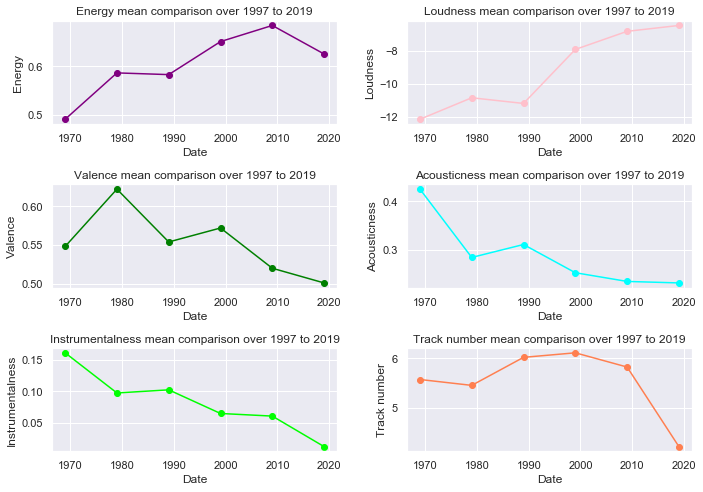

In [12]:
warnings.filterwarnings(action='once')
mean_map = mean_data_generation()
# Create the plot space upon which to plot the data
fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(10, 7))
color_map = {'Energy' :'purple', 'Loudness': 'pink', 'Valence':'green',
            'Acousticness':'cyan', 'Instrumentalness':'lime','Track number':'coral'}
r = 0 
c = 0
for key in mean_map.keys():
    sns.set()
    data_frame = mean_map[key]
    # Add the x-axis and the y-axis to the plot
    ax[r][c].plot(data_frame.index.values,data_frame,'-o',color=color_map[key])
    # Set title and labels for axes
    ax[r][c].set(xlabel="Date",ylabel=key,title= key +" mean comparison over 1997 to 2019")
    ax[r][c].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    c = c + 1
    if (c >= 2 ):
        r = r + 1
        c = 0
    if ( r > 2):
        break


fig.tight_layout()
plt.show()

We keep in mind that data for 2019 is still in collection. Overall, we observe that:

<b>Loudness</b> and <b>Energy</b> show increasing trends. Based on the definitions of these features, this implies that top viral songs are highly intense, fast, and noisy ([4](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)). <br>

<b>Instrumentalness</b> appears to decrease over the decades and is actually very close to 0 (on a scale from 0.0 to 1.0). This indicates the content of top songs is becoming more vocal-based. Acousticness decreased until 2000 and then increased since. This implies the most popular songs nowadays have less electronic amplification than prior to 2000s ([4](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)).  <br>

<b>Valence</b> seems to be dropping during the past couple decades, indicating popular songs are characterized to be more negative or pessimistic ([4](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)). <br>

<b>Track number</b> appears to be more or less the same except during the last 10 years. Perhaps certain top albums are much smaller in comparison.

We suggest some potential explanations for these trends based on quick research about trending music genres. The increase of loud and energetic songs might be associated with popular culture growth in pop and electronic dance music ([5](https://tactical.wp.rpi.edu/2019/02/28/is-the-modernization-and-increasing-popularity-of-rave-culture-having-negative-effects-on-the-quality-of-dance-music/)). The decrease in instrumentalness and recent in crease in acousticness might be assoicated with the popularity of rap, hip-hop, and R&B music ([6](https://www.statista.com/statistics/310746/share-music-album-sales-us-genre/)).

### Most Frequent Genres

After some intuition behind the trends in audio features, we decided to collectively observe the top frequencies of genres across our time interval. We used the feature 'artist genres' to do so.

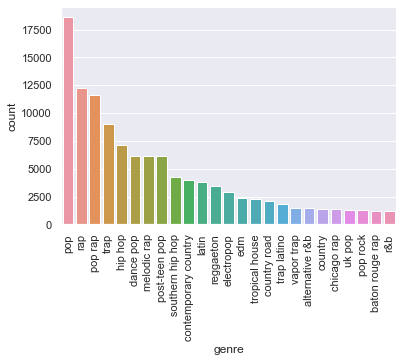

<Figure size 3240x2520 with 0 Axes>

In [13]:
coun = collections.Counter()
years = ['1969','1979','1989','1999','2009','2019']
artist_genres_info = pd.DataFrame()

for year in years:
    df = pd.read_csv(r'./data/' + year +  '.csv', sep='\t')
    artist_genres_info[str(year)] = (df.loc[:, 'artist_genres'])
    
x = ((artist_genres_info.loc[:, str(year)]))
for elem in x: 
    v = ((elem[1:-1].split(", ")))
    v = [year[1:-1] for year in v]
    coun.update(v)
        
df = pd.DataFrame(coun.most_common(25), columns = ['genre', 'count'])
ax = sns.barplot(x="genre", y="count", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.figure(figsize=(45,35))
plt.show()

We observe that rock dominates in frequency, with pop and rap following. Now, let's be more specific and visualize the most common genres in 1969 versus in 2019.

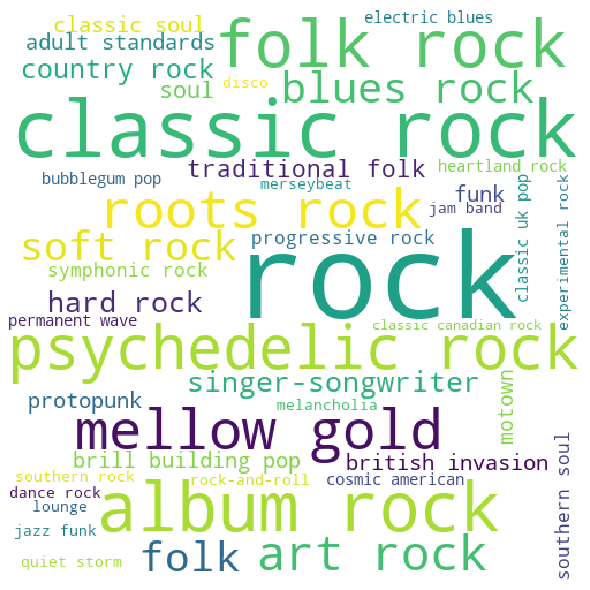

In [14]:
x = (artist_genres_info.loc[:, '1969'])
coun = collections.Counter()
for elem in x: 
    v = ((elem[1:-1].split(", ")))
    v = [year[1:-1] for year in v]
    coun.update(v)
wc = WordCloud(width = 500, height = 500,background_color ='white', min_font_size = 10)
wc.generate_from_frequencies(coun)        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

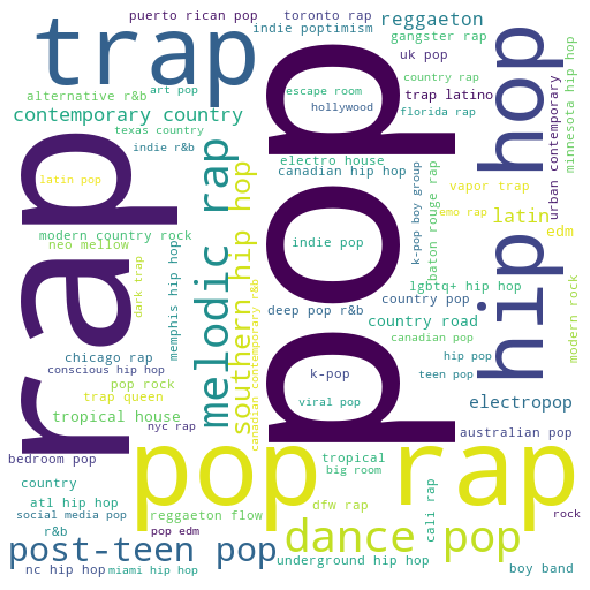

In [15]:
x = (artist_genres_info.loc[:, '2019'])
coun = collections.Counter()
for elem in x: 
    v = ((elem[1:-1].split(", ")))
    v = [year[1:-1] for year in v]
    coun.update(v)
wc = WordCloud(width = 500, height = 500,background_color ='white', min_font_size = 10)
wc.generate_from_frequencies(coun)        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

It appears our genre frequency chart might be dominated by rock in previous decades, as rap and pop seem to be the more common observed genres nowadays.

### Popularity prediction based on audio features
Now that we have seen how the audio features have evolved over time, let's see if we can create a regression model to predict if a given song will be in the top 20% in a given year. We'll use a random forest regressor and train it on 2019's data to see if we can achieve a fair threshold of mean squared error. 

#### Pre Processing
Once we have the data, we need to clean it and change it a little bit for the model to work.We define "popular songs" as those with track popularity score ranking at top 20% of all tracks. We will change the categorical variables to usable values and also transform the popularity into prediction "class" which would be 1 if a song is in the top 20% and 0 if it is not. We also do some other preprocessing required to clean data, remove duplicates and pick only the most important values in the cells if there are multiple values present.

The following functions - reduce_genres, clean_df, bagwords, and generic_cleanup - are preprocessing functions extensively based off this reference: ([7](https://github.com/AsTimeGoesBy111/Spotify-Music-Data-Analysis/blob/gh-pages/Code/Spotify-XGBClassifier.py))

In [150]:
def reduce_genres(gen):
    genre = re.sub("[^a-zA-Z0-9]"," ",gen).lower().split()
    genre = [i for i in genre if i not in set(stopwords.words("english"))]
    most_frequent = collections.Counter(genre).most_common(1)[0][0]
    most_frequent = "'"+most_frequent+"'"
    return most_frequent

In [151]:
def clean_df(names):
    words = re.sub("[^a-zA-Z0-9]"," ",names).lower().split()
    words = [i for i in words if i not in set(stopwords.words("english"))]
    return (" ".join(words)) #joined for use with countvectorizer

In [155]:
def bagwords (df): 
    list_name = ['artist_genres', 'artist_name', 'album_name', 'song_name']
    final_dict = {name: [] for name in list_name}
    final_dict['song_id'] = []
    listid = []
    dicdf = {}
    val = {}
    print(df.shape)
    for name in list_name:
        for idx in range(df[name].size):
            original_val = df[name][idx]
            changed_val = clean_df(original_val)
            final_dict[name].append(changed_val) 

        vectorizer = CountVectorizer(analyzer='word',max_features=30)
        feature = vectorizer.fit_transform(final_dict[name]).toarray().tolist()
        val[name] = vectorizer.get_feature_names()
        dicdf[name] = pd.DataFrame({name: feature}) 
        dicdf[name] = dicdf[name][name].apply(pd.Series)
        ### dicdf[name] already lose column tag name, but change into 0 1 2 
        length = len(dicdf[name].columns)
        dicdf[name].columns = [(name + '_' +val[name][x]) for x in range(length)]
        #print('good')
    for idx in range(df['song_id'].size):
        sid = df['song_id'][idx]
        listid.append(sid)    
        dicdf['song_id'] = pd.DataFrame({'song_id':listid}) 
    result = pd.concat(dicdf.values(), axis =1)
    return result

In [156]:
# generic cleanup dropping na and dropping columns which are not of our interest 
# also categorical variables are converted to values

def generic_cleanup (df):
    df = df.dropna()#drops null values
    df = df.drop(['album_genres'],axis =1 )#column not needed
    df['explicit'] = df['explicit'].map( {True: 1, False: 0} ).astype(int) 
    threshold = df['popularity'].quantile(0.8)
    df['class'] = df['popularity'].apply(lambda x: 1 if x >= threshold else 0) #takes 20% of all tracks
    df = df[(df.astype(str)['artist_genres'] != '[]')].reset_index()
    df['reduced_genres'] = df['artist_genres'].apply(lambda x: reduce_genres(x))
    df['year'] = [x.split('-')[0] for x in df['album_release_date']]
    return df

In [157]:
warnings.filterwarnings('ignore')
df = pd.read_csv(r'./data/2019.csv', sep='\t')
df = generic_cleanup(df)
df1 = bagwords( df )
df = df.merge(df1, on='song_id', how='outer')

(48779, 30)


#### Training the model

Once we have cleaned the data up, we split data into training and test dataset and use a random forest regressor regression model. We have also dropped a few of the columns which would just increase the noise in the data and do not give us any valuable insights. For our analysis we will take 2019 as the year.  We used the following reference for model setup: ([7](https://github.com/AsTimeGoesBy111/Spotify-Music-Data-Analysis/blob/gh-pages/Code/Spotify-XGBClassifier.py))

In [158]:
#training
Y = df['class'].values
df = df.drop(['Unnamed: 0', 'song_id', 'artist_id','album_id','song_name',
            'artist_name','album_name', 'type', 'artist_genres','album_release_date','popularity',
            'class','index','reduced_genres'],axis=1)   
X = df.values     
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.33, random_state=42)
model = RandomForestRegressor(n_estimators=200,max_features=17)
model.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=17, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [159]:
#validation on train dataset
train_predict = model.predict(X_train)
mse_train = mean_squared_error(Y_train, train_predict)
print("training error:",mse_train)

#validation on test dataset
test_predict = model.predict(X_test)
mse_test = mean_squared_error(Y_test,test_predict)
print("test error:",mse_test)

training error: 1.941261465866722e-08
test error: 1.9835989693231106e-07


Hence, given the data for the rest of the year, we can fairly predict whether a new song with given features could be popular or not. This model could be used by music producers and could be extremely uselful to them.
#### Important features
Now that we have trained and tested the models let us see which features played an important role in calculating track popularity

In [135]:
# all features rated
importance = model.feature_importances_

dfi = pd.DataFrame(importance, index=df.columns, columns=["Importance"])
dfi = dfi.sort_values(['Importance'],ascending=False)
# showing those features which are at least significant.
df_plot = dfi[dfi.Importance > 0.01]

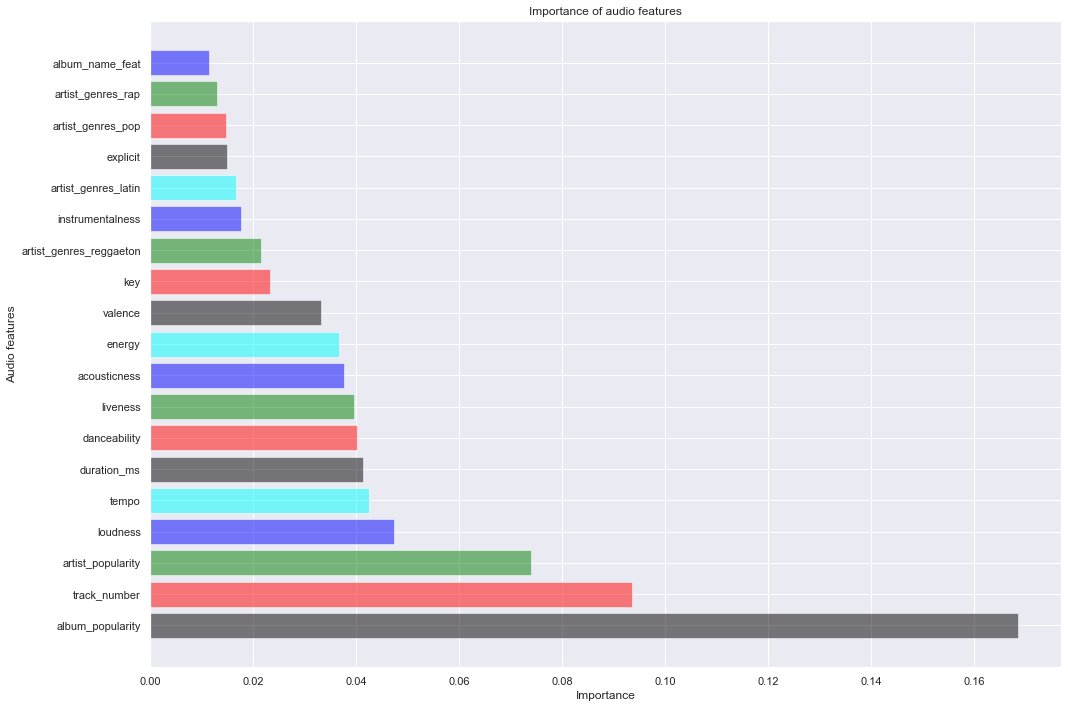

In [137]:
#Let's visualize the importance
sns.set()
plt.figure(figsize=(15,10))    
plt.barh(df_plot.index, df_plot['Importance'], align='center', alpha=0.5,
         color=['black', 'red', 'green', 'blue', 'cyan'])
plt.xlabel("Importance")
plt.ylabel("Audio features")
plt.title("Importance of audio features")


plt.tight_layout()

#### Visualize features
We use a word cloud to visualize the important features. Each feature is weighted according to their importance. This is just another way to represent the above graph which some people find to be more intuitive.

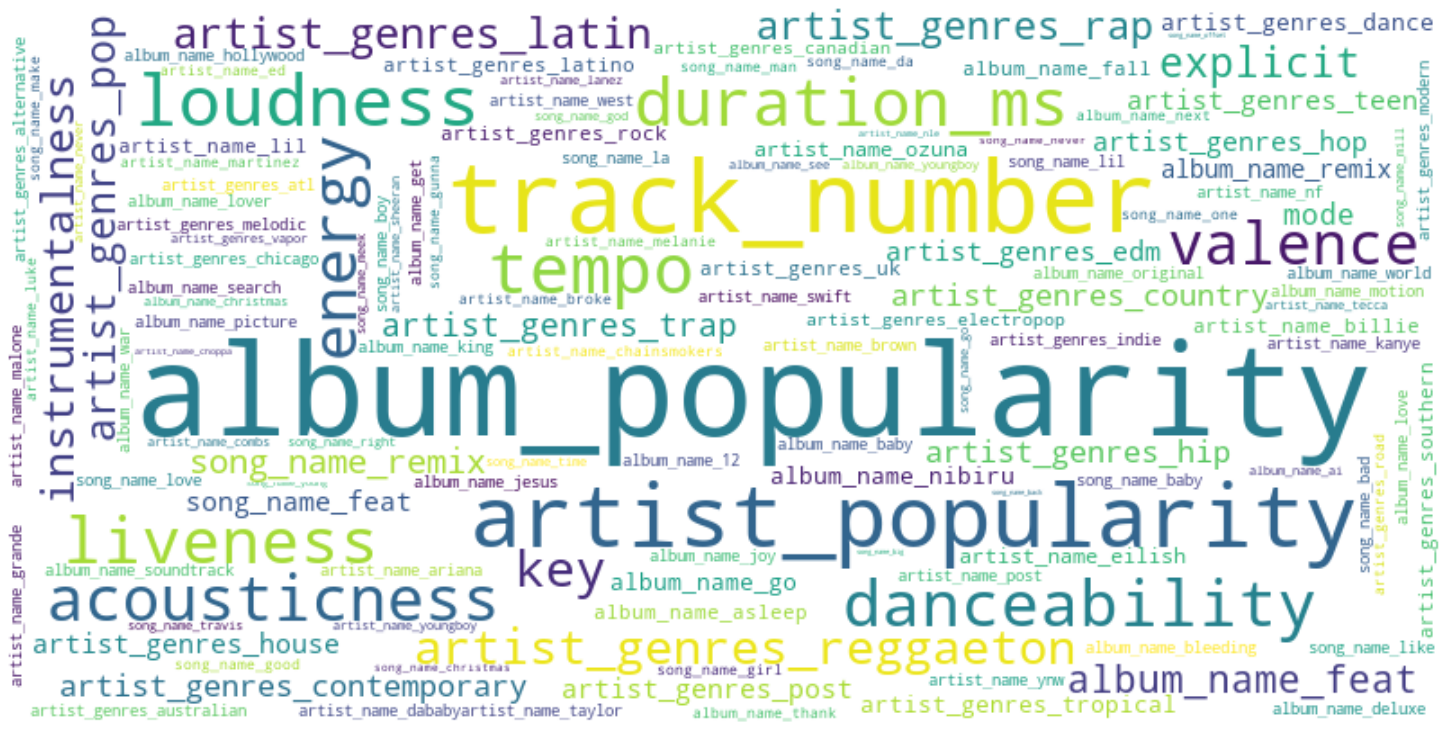

In [138]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wc = WordCloud(width = 800, height = 400,background_color ='white',stopwords = stopwords)
weights = {}
idx = 0
arr = np.array(dfi)
keys = np.array(dfi.index)


idx = 0
for i in keys:
    weights[i]= arr[idx][0]
    idx +=1

wc.generate_from_frequencies(weights)                       
plt.figure(figsize = (20, 10)) 
plt.imshow(wc,interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

This gives us an idea of what makes a track 'popular' by Spotify standards: album popularity, artist popularity, and loudness seem to be some of the most impactful features.
## Other Trends in Music
### Lyrics Over Time
In our previous analysis, we have shown how people's taste in audio features has evolved over the past six decades. get a more holistic view of the trends in music we looked at how lyrics have evolved over the last six decades. We were motivated by this reference ([8](https://github.com/guoguo12/billboard-charts)), which provides billboard.py, a Python API to access chart data from Billboard.com.

#### PreProcess
We start by writing a preprocessor which will tokenize and lemmatize and remove the known stopwords from the lyrics data.

In [26]:
def preprocess(text, stopwords={}, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    stopwords1 = set(['oh','ba','wa','na','im','youre','like','aint','yeah','dont','know','wan','go','get','make'
                     ,'got','em'])
    stopwords.update(stopwords1)
    text = text.lower()
    text = text.replace("'s","").replace("'","")
    text = re.sub(r'[^a-zA-z]',' ',text)
    token_text = nltk.word_tokenize(text)
    token_text = [lemmatizer.lemmatize(t) for t in token_text]
    token_text = [t for t in token_text if t not in stopwords]
    return token_text

#### Fetch the Data
The next step is to fetch the top 30 records from the billboard API and fetch their lyrics for . We will later use theselyrics after preprocessing to see how they have eveloved.

In [27]:
def fetch_data():
    year = 1969
    data = collections.defaultdict(list)
    for _ in range(6):
        chart_date = str(year)+"-07-15"
        chart = billboard.ChartData('hot-100',date=chart_date)
        track_count = 0
        for i,track in zip(range(100),chart):
            if track_count == 30: break
            artist = re.sub(r' Featuring.*','',track.artist)
            try:
                a = PyLyrics.getLyrics(artist,track.title)
            except ValueError as e:
                continue
            data[year].append((track.title,track.artist,a))
            track_count +=1
        year += 10
    return data

In [36]:
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
data = fetch_data()

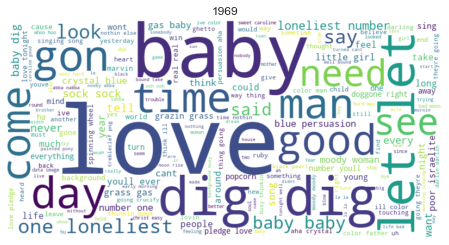

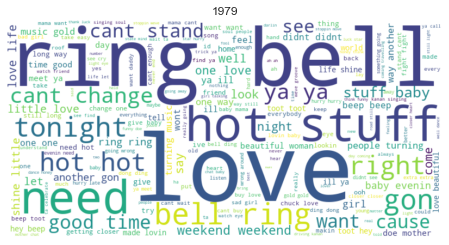

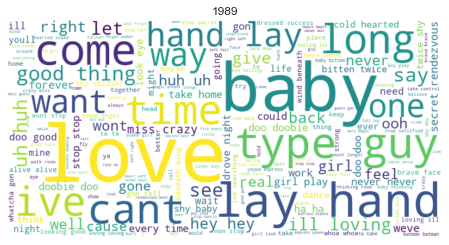

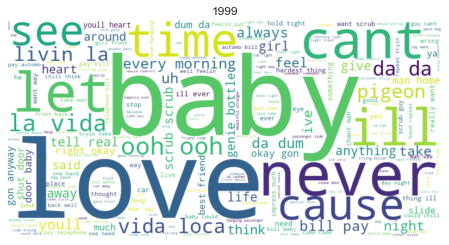

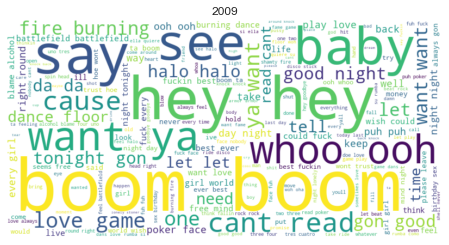

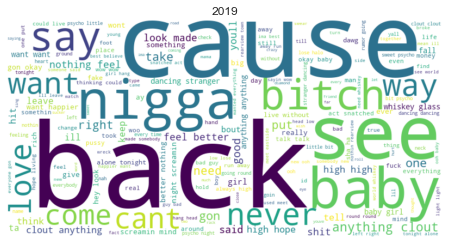

In [41]:
artist_dict = {'Zager & Evans': 'M', 'Blood, Sweat & Tears': 'M', 'Oliver': 'M', 'Tommy James And The Shondells': 'M', 'Jr. Walker & The All Stars': 'M', 'Three Dog Night': 'M', 'The Winstons': 'M', 'The Beatles': 'M', 'Stevie Wonder': 'M', 'Creedence Clearwater Revival': 'M', 'James Brown': 'M', 'Tom Jones': 'M', 'Andy Kim': 'M', 'Marvin Gaye': 'M', 'Elvis Presley': 'M', 'Sonny Charles And The Checkmates, Ltd.': 'M', 'Kenny Rogers & The First Edition': 'M', 'Paul Revere & The Raiders Featuring Mark Lindsay': 'M', 'The Isley Brothers': 'M', 'Neil Diamond': 'M', 'Jerry Butler': 'M', 'The Joe Jeffrey Group': 'M', 'Desmond Dekker And The Aces': 'M', 'The Friends Of Distinction': 'M', 'Roy Clark': 'M', 'The Impressions': 'M', 'Smokey Robinson & The Miracles': 'M', 'Bobby Vinton': 'M', 'Donna Summer': 'F', 'Anita Ward': 'F', 'Chic': 'F', 'David Naughton': 'M', 'Cheap Trick': 'M', 'Electric Light Orchestra': 'M', 'John Stewart': 'M', 'Kenny Rogers': 'M', 'Dr. Hook': 'M', 'Rickie Lee Jones': 'M', 'McFadden & Whitehead': 'M', 'Peter Frampton': 'M', 'Raydio': 'M', 'Barbra Streisand': 'F', 'Gerry Rafferty': 'M', 'KISS': 'M', 'ABBA': 'F', 'Poco': 'M', 'Elton John': 'M', 'Atlanta Rhythm Section': 'M', 'Wings': 'M', 'Supertramp': 'M', 'Anne Murray': 'F', 'Kansas': 'M', 'Maxine Nightingale': 'F', 'James Taylor': 'M', 'Blondie': 'F', 'Wet Willie': 'M', 'Joe Jackson': 'M', 'Simply Red': 'M', 'Madonna': 'F', 'Fine Young Cannibals': 'M', 'Martika': 'F', 'Milli Vanilli': 'M', 'Prince': 'M', 'Natalie Cole': 'F', 'Expose': 'F', 'The Doobie Brothers': 'M', 'Love And Rockets': 'M', 'Cyndi Lauper': 'F', 'Bobby Brown': 'M', 'Bon Jovi': 'M', 'Richard Marx': 'M', 'Rod Stewart': 'M', 'Great White': 'M', 'Tom Petty': 'M', 'Dino': 'M', 'Neneh Cherry': 'F', 'Stevie Nicks': 'F', 'New Kids On The Block': 'M', 'Roxette': 'F', 'Bette Midler': 'F', 'Paul McCartney': 'M', 'Real Life': 'M', 'Karyn White': 'F', 'Debbie Gibson': 'F', 'Paula Abdul': 'F', 'LL Cool J': 'M', "Destiny's Child": 'F', 'Jennifer Lopez': 'F', 'Pearl Jam': 'M', 'Christina Aguilera': 'F', 'Ricky Martin': 'M', 'Backstreet Boys': 'M', 'Whitney Houston': 'F', 'Will Smith Featuring Dru Hill & Kool Mo Dee': 'M', '702': 'F', 'Smash Mouth': 'M', 'Maxwell': 'M', '98 Degrees': 'M', 'TLC': 'F', 'Sporty Thievz Featuring Mr. Woods': 'M', 'Sixpence None The Richer': 'F', 'Blaque': 'F', 'Shania Twain': 'F', 'Sarah McLachlan': 'F', 'Chante Moore': 'F', 'Case': 'M', 'Phil Collins': 'M', 'Britney Spears': 'F', 'Brandy': 'F', "112 Featuring Lil'z": 'M', 'K-Ci & JoJo': 'M', 'Sugar Ray': 'M', 'Goo Goo Dolls': 'M', 'Lonestar': 'M', 'Tim McGraw': 'M', 'The Black Eyed Peas': 'M', 'Drake': 'M', 'Keri Hilson Featuring Kanye West & Ne-Yo': 'F', 'Lady Gaga': 'F', 'Sean Kingston': 'M', 'Jeremih': 'M', 'Pitbull': 'M', 'Taylor Swift': 'F', 'Linkin Park': 'M', '3OH!3': 'M', 'Colbie Caillat': 'F', 'Katy Perry': 'F', 'Young Money': 'M', 'Beyonce': 'F', 'Miley Cyrus': 'F', 'Shinedown': 'M', 'P!nk': 'F', 'Kings Of Leon': 'M', 'Nickelback': 'M', 'Jamie Foxx Featuring T-Pain': 'M', 'Rob Thomas': 'M', 'Kid Cudi': 'M', 'Kristinia DeBarge': 'F', 'Zac Brown Band': 'M', 'Flo Rida': 'M', 'Billy Currington': 'M', 'Jason Mraz': 'M', 'Jordin Sparks': 'F', 'Billie Eilish': 'F', 'Khalid': 'M', 'Jonas Brothers': 'M', 'Post Malone & Swae Lee': 'M', 'Post Malone': 'M', 'Sam Smith & Normani': 'F', 'Panic! At The Disco': 'M', 'Halsey': 'F', 'Marshmello & Bastille': 'M', 'Ariana Grande': 'F', 'Ava Max': 'F', 'Morgan Wallen': 'M', 'City Girls': 'F', 'J. Cole': 'M', 'Dan + Shay': 'M', 'Lee Brice': 'M', 'Lewis Capaldi': 'M', 'benny blanco, Halsey & Khalid': 'F', 'Meek Mill Featuring Drake': 'M', 'Lady Gaga & Bradley Cooper': 'F', 'Eric Church': 'M', 'Travis Scott': 'M', 'Maren Morris': 'F', 'Offset Featuring Cardi B': 'M', 'Jason Aldean': 'M', 'Kane Brown': 'M'}
for year in range(1969,2020,10):
    all_lyrics = ""
    for title, artist, lyrics in data[year]:
        all_lyrics = all_lyrics+" "+" ".join(preprocess(lyrics))
    wc = WordCloud(width=800,height=400,background_color="white",stopwords = ['oh','ba','wa','na','im','youre','like','aint','yeah','dont','know']).generate(re.sub(r"\s+"," ", all_lyrics))
    plt.figure( figsize=(8,4) )
    plt.imshow(wc,interpolation='bilinear')
    plt.axis("off")
    plt.title(year)
    plt.show()

Over the years, lyrics have evolved significantly. From 60s through 90s, 'love' and 'baby' were an important part of music as is shown by the above wordclouds. But over time, we see the relative frequency of these words decreasing until 2009 where we have to look really hard to find these words. Moreover, we can see that profanity is now prevailent in popular music in 2019. Looks like we now want more bad words in our music !
### Gender Trends
Here we look at how gender has played a role over time. We looked at the popular music and found the percentages of females in top charts as well as how different the music made by males and females is based on the type of lyrics used.

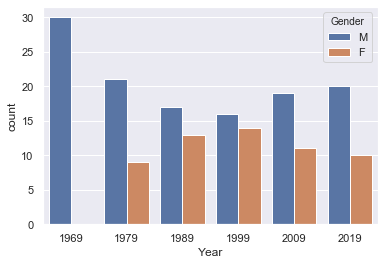

In [39]:
total_array = []
for year in range(1969,2020,10):
    male_count = 0
    f_count = 0
    temp_array = []
    for title, artist, lyrics in data[year]:
        temp_array.append(artist_dict[artist])
    total_array.append(temp_array)
        
total_array = np.array(total_array)
df = pd.DataFrame(total_array.T,columns = ['1969','1979','1989','1999','2009','2019'])
df_new = pd.melt(df)
df_new = df_new.rename(columns={"variable": "Year","value":"Gender"})
sns.countplot(x="Year", hue="Gender", data=df_new)
plt.show()

Women have increasingly started to represent a higher percentage the top 30 charts over time. From zero representation in the sixties to almost half in recent times gender equality has come a long way over time.

Now lets dig a little deeper and find out what were the top ten words used by females and by males in recent times. This would give us some insight into how gender plays a role in song lyrics in the 21st century. We have done this analysis just for 2019 but the user can change the years in the below loop to find out the popular lyrics for whichever range of years they want to find the results.

In [51]:
female_lyrics = []
male_lyrics = []
for year in range(2019,2020,10):
    for title, artist, lyrics in data[year]:
        if artist_dict[artist] == 'M':
            male_lyrics.append(preprocess(lyrics))
        else:
            female_lyrics.append(preprocess(lyrics))
    
    
female_lyrics = sum(female_lyrics,[])
male_lyrics = sum(male_lyrics,[])
female_counter = collections.Counter(female_lyrics)
male_counter = collections.Counter(male_lyrics)

('baby', 'want', 'dancing', 'mind', 'girl', 'tonight', 'psycho', 'bad', 'away', 'guy')


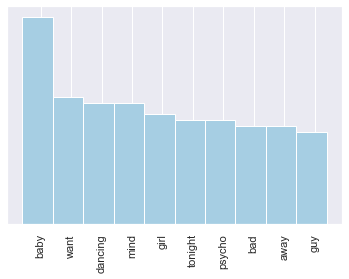

('want', 'back', 'high', 'anything', 'feel', 'see', 'clout', 'cause', 'never', 'baby')


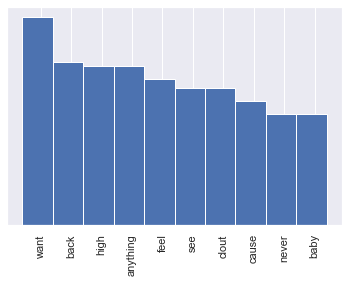

In [52]:
labels,values = zip(*female_counter.most_common(10))
print(labels)
indexes = np.arange(len(labels))
width = 1
sns.set_palette("Paired")
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.1, labels,rotation = 90)
plt.yticks([])
plt.show()
labels,values = zip(*male_counter.most_common(10))
print(labels)
indexes = np.arange(len(labels))
width = 1
sns.set()
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.1, labels,rotation = 90)
plt.yticks([])
plt.show()

This analysis does show some interesting things. While females were most likely to write about dancing, guys and girls, males showed a fairly different trend by writing about feelings, girls and not surprisingly, getting high.

###  Final Word
In this analysis of musical trends over certain markers during the last six decades, we did get to see some pretty interesting trends but more importantly we got to see what scientific factors makes music, which is such an important part of our daily lives, make us click with it. The analysis proves that music and our liking of the type of music is constantly evolving and that it might have a completely different roadmap in the future.

### Citations
- [Spotipy](https://spotipy.readthedocs.io/en/latest/)
- [PyLyrics](https://pypi.org/project/PyLyrics/) <br> <br>

- [1 - Spotify Metadata Info](https://artists.spotify.com/blog/metadata-what-it-is-and-why-it-matters) <br>
- [2 - Spotify Developers Auth](https://developer.spotify.com/documentation/general/guides/authorization-guide/) <br>
- [3 - Motivation](https://github.com/AsTimeGoesBy111/Spotify-Music-Data-Analysis/blob/gh--pages/Code/Spotify_Extract_API_Data.py) <br>
- [4 - Spotify Features Info](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) <br>
- [5 - Research](https://tactical.wp.rpi.edu/2019/02/28/is-the-modernization-and-increasing-popularity-of-rave-culture-having-negative-effects-on-the-quality-of-dance-music/) <br>
- [6 - Research](https://www.statista.com/statistics/310746/share-music-album-sales-us-genre/) <br>
- [7 - Spotify Data Motivation](https://github.com/AsTimeGoesBy111/Spotify-Music-Data-Analysis/blob/gh-pages/Code/Spotify-XGBClassifier.py) <br>
- [8 - Billboard Data Motivation](https://github.com/guoguo12/billboard-charts) <br>

### Further Resources
- [Music Industry Benefitted by AI](https://www.complex.com/music/2019/09/data-changing-music-industry)
- [NLP for Lyrics Analysis](https://medium.com/@alexwbell/music-lyrics-analysis-using-natural-language-processing-to-create-a-lyrics-based-music-recommender-43e35896a4de)
- [Spotify Recommendation System](https://outsideinsight.com/insights/how-ai-helps-spotify-win-in-the-music-streaming-world/)